Sentiment analysis of movie (IMDB) reviews using dataset provided by the ACL 2011 paper, 
see http://ai.stanford.edu/~amaas/data/sentiment/
This notebook uses neural net models

The plan is to compare a variety of hyperparameters, vectorization techniques, neural net based models:
* dense neural network with bag of words
* dense neural network with fixed size input and words mapped to integers
* LSTM
* CNN


### Table of Contents<a class="anchor" id="table"></a>
* [Load data](#load)
* [Train different architectures](#train)
    * [Train NN 50 - 10 - 1](#train1)
    * [Train NN 256 - 128 - 1](#train2)
    * [Train NN with K-Fold cross validation](#kfold)
    * [Train RNN](#rnn)
* [Optimize](#opti)
    * [Optimize on dropouts](#opti_d)
        * no dropout
        * low dropout on 1 layer
        * high dropout on 1 layer
        * low dropout on 2 layers
        * high dropout on 2 layers
        * [Observation](#opti_d_o)

In [97]:
!pip install wget

In [98]:
import numpy as np
import os
import os.path
import glob
import time
import string

import pandas as pd
import matplotlib as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.model_selection import KFold

In [100]:
import wget
import tarfile

# By checking if the directory exists first, we allow people to delete the tarfile without the notebook re-downloading it
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        #!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    #!tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")

Dataset directory exists, taking no action


In [0]:
def foundGPU():
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print('No GPU found')
    return False
  else: 
    print('Found GPU at: {}'.format(device_name))
    return True

In [102]:
# configuration
if foundGPU():
  SAMPLE_SIZE=12500
else:
  SAMPLE_SIZE=2000

BATCH_SIZE=64
TRAIN_TEST_RATIO=0.25
TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

Found GPU at: /device:GPU:0


<a href='#table'>Back</a>
# Load data<a class="anchor" id="load"></a>

## Create a dense vector from reviews 

In [0]:
time_beginning_of_notebook = time.time()
SLICE = int(SAMPLE_SIZE / 2)
positive_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
positive_sample_file_list = positive_file_list[:SLICE]

negative_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
negative_sample_file_list = negative_file_list[:SLICE]

import re

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text

In [0]:
positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_tokenized = [word_tokenize(s) for s in positive_strings]
negative_tokenized = [word_tokenize(s) for s in negative_strings]

In [105]:
print(negative_tokenized[:100])

[['The', 'basic', 'plot', 'in', 'this', 'movie', 'is', "n't", 'bad', '.', 'A', 'lady', 'makes', 'it', 'big', 'and', 'comes', 'back', 'to', 'her', 'alma', 'mater', 'to', 'be', 'adored', '.', 'But', ',', 'despite', 'good', 'acting', 'by', 'Robert', 'Young', 'and', 'Eve', 'Arden', ',', 'the', 'movie', 'is', 'a', 'mess', '.', 'The', 'blame', 'for', 'this', 'I', 'place', 'on', 'either', 'Joan', 'Crawford', 'or', 'the', 'director', 'or', 'both', ',', 'as', 'her', 'performance', 'is', 'just', 'awful', '.', 'Instead', 'of', 'being', 'a', 'real', 'person', ',', 'she', 'does', 'a', 'wonderful', 'impersonation', 'of', 'a', 'deer', 'caught', 'in', 'the', 'headlights', '.', 'In', 'other', 'words', ',', 'she', 'stares', 'off', 'into', 'space', 'and', 'has', 'a', '``', 'golly', 'I', 'am', 'SOOOO', 'stunned', "''", 'expression', '.', 'After', 'just', 'a', 'few', 'minutes', 'it', 'really', 'became', 'annoying', 'for', 'me', '.', 'Now', 'this', 'is', 'certainly', 'not', 'the', 'only', 'Crawford', 'film'

In [0]:
from collections import Counter
import numpy as np

In [0]:
stop = stopwords.words('english') + list(string.punctuation) + ["''", '``', '...', "'s", "n't"]

total_counts = Counter()
all_reviews = positive_tokenized + negative_tokenized
for r in all_reviews:
    sig_words = [w.lower() for w in r if w.lower() not in stop]
    for word in sig_words:
        total_counts[word] += 1

In [0]:
VOCAB_SIZE = 1000

vocab = total_counts.most_common(VOCAB_SIZE)
vocab = [t[0] for t in vocab]


In [109]:
print(vocab)

['movie', 'film', 'one', 'like', 'good', 'would', 'even', 'time', 'story', 'really', 'see', 'much', 'well', 'could', 'people', 'get', 'also', 'bad', 'first', 'great', 'made', 'way', 'make', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'acting', 'plot', 'little', 'best', 'never', 'show', 'love', 'life', 'know', 'ever', 'better', 'still', 'end', 'man', '--', 'scenes', 'scene', 'say', "'ve", 'something', 'go', "'m", 'back', 'though', 'real', 'actors', 'watching', 'thing', 'years', 'actually', 'funny', 'work', 'nothing', 'another', 'new', 'makes', 'look', 'find', 'old', 'director', 'going', 'lot', 'every', 'part', 'cast', 'world', 'things', 'us', 'pretty', 'seems', 'young', 'got', 'want', 'quite', 'around', "'re", 'take', 'fact', 'horror', 'ca', 'enough', 'however', 'without', 'big', 'may', 'thought', 'original', 'give', 'long', 'almost', 'times', 'series', 'role', 'right', 'family', 'gets', 'always', 'saw', 'interesting', 'script', 'come', 'must',

In [0]:
# Create a dictionary of words in the vocabulary mapped to index positions
# (to be used in layer_0)
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

In [111]:
print("ID of 'movie' = {}".format(word2index['movie']))

ID of 'movie' = 0


In [0]:
def convert_to_bag(review):
    bag = np.zeros(VOCAB_SIZE)
    for word in review:
        if word in vocab:
          i = word2index[word.lower()]
          bag[i]+=1
    return bag

In [0]:
test_bag = convert_to_bag(all_reviews[0])

In [0]:
all_reviews_encoded = [convert_to_bag(x) for x in all_reviews]

In [115]:
all_reviews_encoded[0].shape

(1000,)

In [0]:
import random

positive_labels = []
for i in range(len(positive_tokenized)):
    positive_labels.append('POSITIVE')
negative_labels = []
for i in range(len(negative_tokenized)):
    negative_labels.append('NEGATIVE')
   

In [0]:
labels = positive_labels + negative_labels

num_lables = []

for val in labels:
    if val == 'POSITIVE':
       num_lables.append(1)
    else:
       num_lables.append(0) 
    

In [0]:
reviews_and_labels = list(zip(all_reviews_encoded, num_lables))
random.shuffle(reviews_and_labels)
reviews, labels = zip(*reviews_and_labels)

In [0]:
labels = np.array(labels)

In [0]:
def saveTrainingMetrics(title):
  df = pd.DataFrame(results.history)
  df=df[df['val_acc']==df.val_acc.max()]
  df=df[df['acc']==df.acc.min()]

  df.reset_index(inplace=True)
    
  df["title"]=[title]
  df["sample_size"]=[SAMPLE_SIZE]
  df["batch_size"]=[BATCH_SIZE]
  df["train_test_ratio"]=[TRAIN_TEST_RATIO]
  df["training_set_size"]=[TRAINING_SET_SIZE]
  df["validation_set_size"]=[VALIDATION_SET_SIZE]
  df["vocab_size"]=[VOCAB_SIZE]  
  df["nb_epochs"]=[EPOCHS]
  df["training_duration_in_secs"]=[training_duration_in_secs]
  df.drop(labels="index",axis=1,inplace=True)
  print(df)
  df.to_csv(path_or_buf=df.iloc[0].title+".csv")

## Create a sparse matrix from reviews (where we keep the order of the words)

In [121]:
positive_strings[0]

"This is an incredible film. I can't remember the last time I saw a Swedish movie this layered. It's funny, it's tragic, it's compelling, and most of all it's a slice of Swedish small town life. It crushes the clichés, and dwells deeper. It makes you feel connected, not only to the main characters, but to all the characters.  Big city girl tracing back to her roots, her small hometown, to celebrate her father's 70th birthday, crossing paths with people she hasn't met in several years. Although the story itself isn't unique, it offers a fresh approach. The center of the story is the relationship between three sisters (on different stages in life), who aren't very close. Or at least don't realize how close they are.  One key reason that makes it so easy to connect to the people in this film is the immaculate cast. First, I'm more than pleased about the fact that there are absolutely no so-called 'A-list' Swedish actors in this film. Usually there is a handful of actors that has the abili

In [0]:
### We need to found out why we need this code and possibly who has written this code
# reviews=[]
# for sentence in positive_strings:
#     reviews.append([sentence,1])
# for sentence in negative_strings:
#     reviews.append([sentence,0])
# random.shuffle(reviews)


In [0]:
# tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',\
#                                    lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

In [0]:
# len(reviews)

<a href='#table'>Back</a>
# Train models<a class="anchor" id="train"></a>
## Train NN 50 - 10 - 1 <a class="anchor" id="train1"></a>


In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [125]:
X_train

array([[ 0., 18.,  1., ...,  0.,  0.,  0.],
       [ 7.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., 10.,  0., ...,  0.,  0.,  0.]])

In [126]:
startTime=time.time()
model = keras.Sequential()
model.add(layers.Dense(50, activation = "relu", input_shape=(VOCAB_SIZE, )))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 50)                50050     
_________________________________________________________________
dense_22 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 50,571
Trainable params: 50,571
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
   metrics = ["accuracy"]
)

In [128]:
EPOCHS=20
results=model.fit(
   X_train, y_train,
   epochs=EPOCHS,
   validation_data=(X_test, y_test),
   batch_size=BATCH_SIZE
  )
endTime=time.time()

Train on 9375 samples, validate on 3125 samples
Epoch 1/20
9375/9375 [==============================] - 1s 126us/sample - loss: 0.4856 - acc: 0.7698 - val_loss: 0.4029 - val_acc: 0.8349
Epoch 2/20
9375/9375 [==============================] - 1s 90us/sample - loss: 0.3312 - acc: 0.8620 - val_loss: 0.3961 - val_acc: 0.8413
Epoch 3/20
9375/9375 [==============================] - 1s 89us/sample - loss: 0.2768 - acc: 0.8891 - val_loss: 0.4019 - val_acc: 0.8413
Epoch 4/20
9375/9375 [==============================] - 1s 91us/sample - loss: 0.2290 - acc: 0.9154 - val_loss: 0.4234 - val_acc: 0.8326
Epoch 5/20
9375/9375 [==============================] - 1s 88us/sample - loss: 0.1756 - acc: 0.9385 - val_loss: 0.4438 - val_acc: 0.8282
Epoch 6/20
9375/9375 [==============================] - 1s 92us/sample - loss: 0.1261 - acc: 0.9603 - val_loss: 0.4781 - val_acc: 0.8317
Epoch 7/20
9375/9375 [==============================] - 1s 91us/sample - loss: 0.0812 - acc: 0.9794 - val_loss: 0.5472 - val_acc:

In [129]:
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Train NN 50 - 10 - 1")

        acc      loss  val_acc  val_loss                         title  \
0  0.861973  0.331242  0.84128  0.396138  Opti-NN-Train NN 50 - 10 - 1   

   sample_size  batch_size  train_test_ratio  training_set_size  \
0        12500          64              0.25               9375   

   validation_set_size  vocab_size  nb_epochs  training_duration_in_secs  
0                 3125        1000         20                  18.424121  


## Train NN 256 - 128 - 1 <a class="anchor" id="train2"></a>

In [0]:
startTime=time.time()
model = keras.Sequential([
    layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [133]:
EPOCHS=5
results = model.fit(
 X_train, y_train,
 epochs=EPOCHS,
 validation_data=(X_test, y_test),
batch_size=BATCH_SIZE
)

Train on 9375 samples, validate on 3125 samples
Epoch 1/5
9375/9375 [==============================] - 1s 133us/sample - loss: 0.4422 - acc: 0.7965 - val_loss: 0.3908 - val_acc: 0.8336
Epoch 2/5
9375/9375 [==============================] - 1s 90us/sample - loss: 0.2823 - acc: 0.8838 - val_loss: 0.3924 - val_acc: 0.8368
Epoch 3/5
9375/9375 [==============================] - 1s 93us/sample - loss: 0.1693 - acc: 0.9383 - val_loss: 0.4467 - val_acc: 0.8285
Epoch 4/5
9375/9375 [==============================] - 1s 93us/sample - loss: 0.0601 - acc: 0.9836 - val_loss: 0.6005 - val_acc: 0.8314
Epoch 5/5
9375/9375 [==============================] - 1s 93us/sample - loss: 0.0165 - acc: 0.9970 - val_loss: 0.7539 - val_acc: 0.8275


In [134]:
results.history

{'acc': [0.79648, 0.88384, 0.9383467, 0.9835733, 0.99701333],
 'loss': [0.4421726690896352,
  0.2823379472875595,
  0.16927311407327653,
  0.06012259160041809,
  0.016521675756623347],
 'val_acc': [0.8336, 0.8368, 0.82848, 0.83136, 0.82752],
 'val_loss': [0.39082043525695803,
  0.39239724227905276,
  0.4467250364303589,
  0.6005179628562928,
  0.7538636566352844]}

In [135]:
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Train NN 256 - 128 - 1")

       acc      loss  val_acc  val_loss                           title  \
0  0.88384  0.282338   0.8368  0.392397  Opti-NN-Train NN 256 - 128 - 1   

   sample_size  batch_size  train_test_ratio  training_set_size  \
0        12500          64              0.25               9375   

   validation_set_size  vocab_size  nb_epochs  training_duration_in_secs  
0                 3125        1000          5                   6.271968  


## Train NN with K-Fold cross validation <a class="anchor" id="kfold"></a>

In [0]:
from keras.callbacks import History

def getBestResultsFrom(bestResults,results):
  if bestResults is None:
    return results
  
  bestResultsDf = pd.DataFrame(data=bestResults.history)
  bestResultsDf=bestResultsDf.sort_values(['val_acc'], ascending=False)
  resultsDf = pd.DataFrame(data=results.history)
  resultsDf=resultsDf.sort_values(['val_acc'], ascending=False)
  
  if bestResultsDf['val_acc'].iloc[0] > resultsDf['val_acc'].iloc[0]:    
    return bestResults
  
  if bestResultsDf['val_acc'].iloc[0] == resultsDf['val_acc'].iloc[0]:
    if bestResultsDf['acc'].iloc[0] < resultsDf['acc'].iloc[0]:
      return bestResults
    else:
      return results

  return results

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [0]:
FOLDS=3
kfold = KFold(FOLDS, True, 1)

In [0]:
train_data = list(zip(X_train, y_train))

In [140]:
train_data[0][0].shape

(1000,)

In [0]:
EPOCHS=5
SAMPLE_SIZE=len(X_train)
TRAIN_TEST_RATIO=(1/FOLDS)
TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)
histories=[]

In [142]:
startTime=time.time()
bestResults=None
for train_indices, test_indices in kfold.split(X_train,y=y_train):
    model = keras.Sequential([
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE,)),
      layers.Dense(128, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(
      optimizer = "adam",
      loss = "binary_crossentropy",
      metrics = ["accuracy"]
    )
    K_X_train = X_train[train_indices]
    K_y_train = y_train[train_indices]
    K_X_test = X_train[test_indices]
    K_y_test = y_train[test_indices]
    results=model.fit(
      K_X_train, K_y_train,
      epochs=EPOCHS,
      validation_data=(K_X_test, K_y_test),
      batch_size=BATCH_SIZE
    )
    histories.append(results.history)
    bestResults=getBestResultsFrom(bestResults,results)
    
results=bestResults
endTime=time.time()

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 164us/sample - loss: 0.4634 - acc: 0.7816 - val_loss: 0.4131 - val_acc: 0.8314
Epoch 2/5
6250/6250 [==============================] - 1s 98us/sample - loss: 0.2698 - acc: 0.8982 - val_loss: 0.4395 - val_acc: 0.8208
Epoch 3/5
6250/6250 [==============================] - 1s 102us/sample - loss: 0.1505 - acc: 0.9485 - val_loss: 0.5143 - val_acc: 0.8179
Epoch 4/5
6250/6250 [==============================] - 1s 98us/sample - loss: 0.0551 - acc: 0.9875 - val_loss: 0.6943 - val_acc: 0.8138
Epoch 5/5
6250/6250 [==============================] - 1s 98us/sample - loss: 0.0123 - acc: 0.9990 - val_loss: 0.8444 - val_acc: 0.8144
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 160us/sample - loss: 0.4739 - acc: 0.7790 - val_loss: 0.4083 - val_acc: 0.8237
Epoch 2/5
6250/6250 [==============================] - 1s 99us/sample - loss: 0.2832 

In [143]:
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Train NN with K-Fold cross validation")

       acc      loss  val_acc  val_loss  \
0  0.88384  0.283239  0.84032  0.392032   

                                           title  sample_size  batch_size  \
0  Opti-NN-Train NN with K-Fold cross validation         9375          64   

   train_test_ratio  training_set_size  validation_set_size  vocab_size  \
0          0.333333               6250                 3125        1000   

   nb_epochs  training_duration_in_secs  
0          5                  15.756862  


mean acc: 0.9986666639645895, mean val_acc: 0.8222933212916056


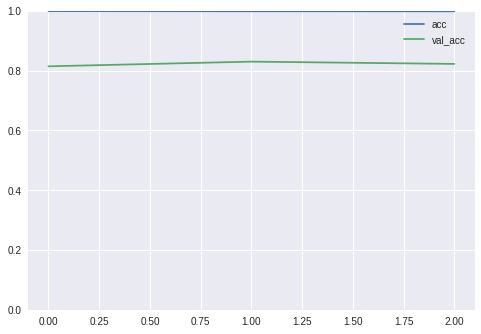

In [144]:
df = pd.DataFrame(data=histories)
for col in df.columns:
    df[col] =  df[col].apply(lambda x: x[-1])
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0,1])

means=df[["acc","val_acc"]].mean()
print("mean acc: {}, mean val_acc: {}".format(means["acc"],means["val_acc"]))

## Train RNN <a class="anchor" id="rnn"></a>

<a href='#table'>Back</a>
# OPTIMIZE<a class="anchor" id="opti"></a>

## Optimize on dropout<a class="anchor" id="opti_d"></a>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [0]:
FOLDS=3
kfold = KFold(FOLDS, True, 1)

In [0]:
train_data = list(zip(X_train, y_train))

In [0]:
from pdb import set_trace

def getMeansFromResultsHistory(histories):
  df = pd.DataFrame(data=histories)
  for col in df.columns:
      df[col] =  df[col].apply(lambda x: x[-1])
  means=df[["acc","val_acc"]].mean()
  return means

def trainModelWithDropoutOn1Layer(epochs_nb=5,rate=0.0):
  EPOCHS=5
  SAMPLE_SIZE=len(X_train)
  TRAIN_TEST_RATIO=(1/FOLDS)
  TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
  VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

  histories=[]
  bestResults=None
  for train_indices, test_indices in kfold.split(X_train,y=y_train):
      model = keras.Sequential([
        layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
        layers.Dropout(rate),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1, activation = "sigmoid")
      ])
      model.compile(
       optimizer = "adam",
       loss = "binary_crossentropy",
       metrics = ["accuracy"]
      )
      K_X_train = X_train[train_indices]
      K_y_train = y_train[train_indices]
      K_X_test = X_train[test_indices]
      K_y_test = y_train[test_indices]
      results=model.fit(
          K_X_train, K_y_train,
          epochs=epochs_nb,
          validation_data=(K_X_test, K_y_test),
          batch_size=BATCH_SIZE
      )
      histories.append(results.history)
      bestResults=getBestResultsFrom(bestResults,results)
  
  means=getMeansFromResultsHistory(histories)
  print(means) 
  return bestResults,means

def trainModelWithDropoutOn2Layers(epochs_nb=5,rate=0.0):
  EPOCHS=5
  SAMPLE_SIZE=len(X_train)
  TRAIN_TEST_RATIO=(1/FOLDS)
  TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
  VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

  histories=[]
  bestResults=None
  for train_indices, test_indices in kfold.split(X_train,y=y_train):
      model = keras.Sequential([
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dropout(rate),
      layers.Dense(1, activation = "sigmoid")
      ])
      model.compile(
       optimizer = "adam",
       loss = "binary_crossentropy",
       metrics = ["accuracy"]
      )
      K_X_train = X_train[train_indices]
      K_y_train = y_train[train_indices]
      K_X_test = X_train[test_indices]
      K_y_test = y_train[test_indices]
      results=model.fit(
          K_X_train, K_y_train,
          epochs=epochs_nb,
          validation_data=(K_X_test, K_y_test),
          batch_size=BATCH_SIZE
      )
      histories.append(results.history)
      bestResults=getBestResultsFrom(bestResults,results)
  
  means=getMeansFromResultsHistory(histories)
  print(means) 
  return bestResults,means

In [0]:
dropout_means=[]

### No dropout


In [150]:
rate=0.0
EPOCHS=5
startTime=time.time()
results,means=trainModelWithDropoutOn1Layer(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,0])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - No dropouts")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 171us/sample - loss: 0.4786 - acc: 0.7790 - val_loss: 0.4050 - val_acc: 0.8256
Epoch 2/5
6250/6250 [==============================] - 1s 99us/sample - loss: 0.2704 - acc: 0.8949 - val_loss: 0.4281 - val_acc: 0.8253
Epoch 3/5
6250/6250 [==============================] - 1s 102us/sample - loss: 0.1550 - acc: 0.9461 - val_loss: 0.4440 - val_acc: 0.8250
Epoch 4/5
6250/6250 [==============================] - 1s 99us/sample - loss: 0.0582 - acc: 0.9867 - val_loss: 0.6099 - val_acc: 0.8182
Epoch 5/5
6250/6250 [==============================] - 1s 98us/sample - loss: 0.0176 - acc: 0.9974 - val_loss: 0.7082 - val_acc: 0.8259
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 170us/sample - loss: 0.4702 - acc: 0.7824 - val_l

### Low dropout on 1 layer

In [151]:
rate=0.2
EPOCHS=5
startTime=time.time()
results,means=trainModelWithDropoutOn1Layer(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - Low dropout on 1 layer")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 186us/sample - loss: 0.4768 - acc: 0.7830 - val_loss: 0.4385 - val_acc: 0.8090
Epoch 2/5
6250/6250 [==============================] - 1s 102us/sample - loss: 0.2918 - acc: 0.8824 - val_loss: 0.4032 - val_acc: 0.8307
Epoch 3/5
6250/6250 [==============================] - 1s 104us/sample - loss: 0.1980 - acc: 0.9229 - val_loss: 0.4592 - val_acc: 0.8234
Epoch 4/5
6250/6250 [==============================] - 1s 101us/sample - loss: 0.1050 - acc: 0.9662 - val_loss: 0.5515 - val_acc: 0.8150
Epoch 5/5
6250/6250 [==============================] - 1s 101us/sample - loss: 0.0486 - acc: 0.9862 - val_loss: 0.6557 - val_acc: 0.8275
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 194us/sample - loss: 0.4905 - acc: 0.7643 - val_loss: 0.3934 - val_acc: 0.8330
Epoch 2/5
6250/6250 [==============================] - 1s 101us/sample - loss: 0.3

### High dropout on 1 layer


In [152]:
rate=0.4
EPOCHS=5
startTime=time.time()
results,means=trainModelWithDropoutOn1Layer(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - High dropout on 1 layer")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 199us/sample - loss: 0.5082 - acc: 0.7474 - val_loss: 0.4066 - val_acc: 0.8256
Epoch 2/5
6250/6250 [==============================] - 1s 100us/sample - loss: 0.3204 - acc: 0.8685 - val_loss: 0.4117 - val_acc: 0.8269
Epoch 3/5
6250/6250 [==============================] - 1s 102us/sample - loss: 0.2429 - acc: 0.9054 - val_loss: 0.4326 - val_acc: 0.8211
Epoch 4/5
6250/6250 [==============================] - 1s 102us/sample - loss: 0.1683 - acc: 0.9378 - val_loss: 0.4687 - val_acc: 0.8221
Epoch 5/5
6250/6250 [==============================] - 1s 102us/sample - loss: 0.1127 - acc: 0.9622 - val_loss: 0.5392 - val_acc: 0.8259
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 202us/sample - loss: 0.5187 - acc: 0.7453 - val_loss: 0.3972 - val_acc: 0.8368
Epoch 2/5
6250/6250 [==============================] - 1s 103us/sample - loss: 0.3

### Low dropout on 2 layers

In [153]:
rate=0.2
EPOCHS=5
startTime=time.time()
results,means=trainModelWithDropoutOn2Layers(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - Low dropout on 2 layers")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 223us/sample - loss: 0.4831 - acc: 0.7658 - val_loss: 0.4074 - val_acc: 0.8240
Epoch 2/5
6250/6250 [==============================] - 1s 107us/sample - loss: 0.3099 - acc: 0.8762 - val_loss: 0.4040 - val_acc: 0.8278
Epoch 3/5
6250/6250 [==============================] - 1s 111us/sample - loss: 0.2106 - acc: 0.9200 - val_loss: 0.4497 - val_acc: 0.8202
Epoch 4/5
6250/6250 [==============================] - 1s 109us/sample - loss: 0.1315 - acc: 0.9523 - val_loss: 0.5028 - val_acc: 0.8198
Epoch 5/5
6250/6250 [==============================] - 1s 106us/sample - loss: 0.0645 - acc: 0.9830 - val_loss: 0.6351 - val_acc: 0.8157
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 231us/sample - loss: 0.4961 - acc: 0.7678 - val_loss: 0.4142 - val_acc: 0.8310
Epoch 2/5
6250/6250 [==============================] - 1s 105us/sample - loss: 0.3

### High dropout on 2 layers


In [154]:
rate=0.4
EPOCHS=5
startTime=time.time()
results,means=trainModelWithDropoutOn2Layers(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - High dropout on 2 layers")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 1s 239us/sample - loss: 0.5360 - acc: 0.7261 - val_loss: 0.4417 - val_acc: 0.8077
Epoch 2/5
6250/6250 [==============================] - 1s 109us/sample - loss: 0.3429 - acc: 0.8576 - val_loss: 0.3949 - val_acc: 0.8282
Epoch 3/5
6250/6250 [==============================] - 1s 108us/sample - loss: 0.2606 - acc: 0.8952 - val_loss: 0.4112 - val_acc: 0.8259
Epoch 4/5
6250/6250 [==============================] - 1s 110us/sample - loss: 0.1948 - acc: 0.9269 - val_loss: 0.4552 - val_acc: 0.8301
Epoch 5/5
6250/6250 [==============================] - 1s 110us/sample - loss: 0.1344 - acc: 0.9549 - val_loss: 0.4996 - val_acc: 0.8269
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 244us/sample - loss: 0.5489 - acc: 0.7269 - val_loss: 0.3994 - val_acc: 0.8298
Epoch 2/5
6250/6250 [==============================] - 1s 108us/sample - loss: 0.3

Plot results

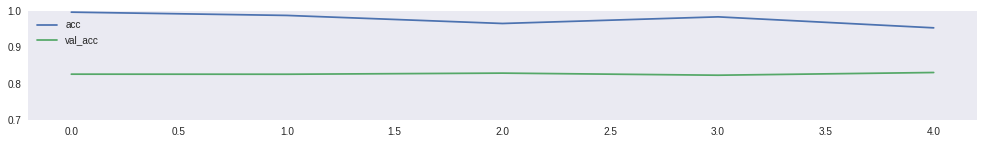

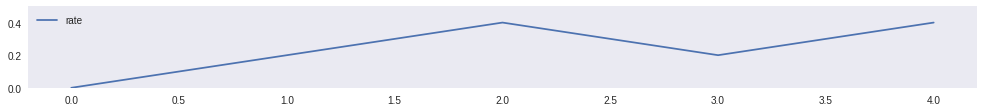

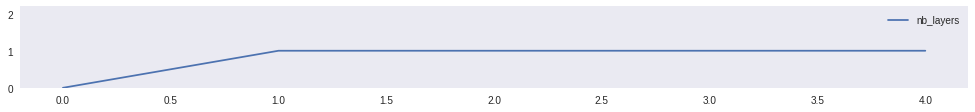

In [155]:
df = pd.DataFrame(data=dropout_means,columns=['acc','val_acc','rate','nb_layers'])
plt.rcParams["figure.figsize"] = [17,2]
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0.7,1])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["rate"]].plot()
plot.set_ylim([0,0.5])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["nb_layers"]].plot()
plot.set_ylim([0,2.2])
plot.grid()

In [156]:
dropout_means

[[0.9970666766166687, 0.8259200056393942, 0.0, 0],
 [0.9880000154177347, 0.8257066607475281, 0.2, 1],
 [0.9657599925994873, 0.8288000027338663, 0.4, 1],
 [0.9840533336003622, 0.8230400085449219, 0.2, 1],
 [0.953760008017222, 0.8305066625277201, 0.4, 1]]

### Observation<a class="anchor" id="opti_d_o"></a>
we have similar results, but got a higher test accuracy with low dropout on all layers and also less overfit (training and test accuracies are closer)